In [2]:
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.impute import SimpleImputer
import scipy as scp

from copy import deepcopy
from natsort import natsorted

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 25, 5

In [3]:
sleep_scoring_df = pd.DataFrame()

pkl_filez = natsorted(glob.glob('/media/HlabShare/james/LFP_and_motion_pkls/*.pkl'))
for pklfile in pkl_filez:
    tmpdf = []
    tmpdf = pd.read_pickle(pklfile)

    sleep_scoring_df = pd.concat([sleep_scoring_df, tmpdf])

In [4]:
file = sleep_scoring_df.query('AnimalName == "CAF37"').sleep_labels.to_numpy()
np.save('/media/HlabShare/Sleep_Scoring/CAF00037/caf3708272020/CAF00037_SleepStates.npy', file)

## Smoothing

In [5]:
# Extract features and sleep labels from dataframe
delta = sleep_scoring_df['delta'].to_numpy()
theta = sleep_scoring_df['theta'].to_numpy()
alpha = sleep_scoring_df['alpha'].to_numpy()
beta = sleep_scoring_df['beta'].to_numpy()
sigma = sleep_scoring_df['sigma'].to_numpy()
motion = sleep_scoring_df['motion'].to_numpy()
gamma = sleep_scoring_df['gamma'].to_numpy()
thetaratio = sleep_scoring_df['thetaratio'].to_numpy()

y = sleep_scoring_df['sleep_labels'].to_numpy()

# # Assuming delta is a NumPy array
# window_size = 10  # Adjust as desired

# # Compute rolling mean using convolution
# #motion_rolling_mean = np.convolve(np.pad(sleep_scoring_df['motion'].to_numpy(), (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# delta_rolling_mean = np.convolve(np.pad(delta, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# theta_rolling_mean = np.convolve(np.pad(theta, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# alpha_rolling_mean = np.convolve(np.pad(alpha, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# beta_rolling_mean = np.convolve(np.pad(beta, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# gamma_rolling_mean = np.convolve(np.pad(gamma, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# sigma_rolling_mean = np.convolve(np.pad(sigma, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# thetaratio_rolling_mean = np.convolve(np.pad(thetaratio, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')
# motion_rolling_mean = np.convolve(np.pad(motion, (window_size-1, 0), mode='constant'), np.ones(window_size)/window_size, mode='valid')

In [6]:
df_RM = pd.DataFrame(
    {
        'delta' : delta,
        'theta' : theta,
        'alpha' : alpha,
        'beta' : beta,
        'gamma' : gamma,
        'sigma' : sigma,
        'thetaratio': thetaratio,
        'motion': motion,
        'Geno' : sleep_scoring_df.Geno,
        'animal': sleep_scoring_df.AnimalName,
        'label' : sleep_scoring_df.sleep_labels
    }
)
df_RM = df_RM.dropna()
df_RM.head()

,delta,theta,alpha,beta,gamma,sigma,thetaratio,motion,Geno,animal,label
6255,0.132964,0.317876,0.195525,0.106984,0.210907,0.214581,0.578032,0.197174,TE4,CAF22,1.0
6256,0.203083,0.320782,0.081938,0.169842,0.178196,0.229804,0.577780,0.197174,TE4,CAF22,1.0
6257,0.178307,0.419322,0.135473,0.111788,0.111710,0.235228,0.463011,0.197174,TE4,CAF22,1.0
6258,0.106156,0.423963,0.152961,0.177532,0.121641,0.245720,0.650618,0.297513,TE4,CAF22,1.0
6259,0.179107,0.181379,0.150880,0.250386,0.185226,0.326581,0.451634,0.297513,TE4,CAF22,1.0


We first work with unsmoothed data to preserve all signal

## Distribution

In [7]:
wave_df = df_RM.iloc[:,0:-3]
wave_df

,delta,theta,alpha,beta,gamma,sigma,thetaratio,motion
6255,0.132964,0.317876,0.195525,0.106984,0.210907,0.214581,0.578032,0.197174
6256,0.203083,0.320782,0.081938,0.169842,0.178196,0.229804,0.577780,0.197174
6257,0.178307,0.419322,0.135473,0.111788,0.111710,0.235228,0.463011,0.197174
6258,0.106156,0.423963,0.152961,0.177532,0.121641,0.245720,0.650618,0.297513
6259,0.179107,0.181379,0.150880,0.250386,0.185226,0.326581,0.451634,0.297513
...,...,...,...,...,...,...,...,...
21595,0.091608,0.224623,0.150012,0.128977,0.268029,0.196986,0.578727,2.820798
21596,0.127490,0.097448,0.157401,0.185524,0.309124,0.248394,0.426000,1.464038
21597,0.099309,0.144937,0.116190,0.176484,0.318599,0.210886,0.648881,8.445077
21598,0.095021,0.165270,0.089287,0.141055,0.386741,0.183163,0.511976,5.856945


## Train test split

In [8]:
X = df_RM.iloc[:, :-5]
Y = df_RM['label']

data = pd.concat((X,Y), axis=1)

In [9]:
index = np.where(np.array([1]*int(X.shape[0]*0.8))==1)
MASK = np.zeros(X.shape[0], dtype='bool')
MASK[index] = 1

train_data = data[MASK]
test_data = data[~MASK]

## Feature generation for training data

In [10]:
window_size = 15
epoch = [num // window_size for num in range(len(train_data))]
train_data['epoch'] = epoch

/hlabhome/wg-mjames/tmp/CCTM/ipykernel_24772/470945732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['epoch'] = epoch


In [11]:
good_epoch = np.where(train_data.groupby('epoch')['label'].apply(lambda x: np.all(x.iloc[0]==x)))[0]
#good_epoch = [True] * train_data.shape[0]

train_data = train_data[[True if epoch in good_epoch else False for epoch in train_data.epoch]]
train_data_epoch = train_data.set_index('epoch')

In [12]:
means = train_data_epoch.groupby('epoch').mean()
stds = train_data_epoch.groupby('epoch').std()
medians = train_data_epoch.groupby('epoch').median()

means_wide = train_data_epoch.groupby(train_data_epoch.index / 3).mean()
stds_wide = train_data_epoch.groupby(train_data_epoch.index / 3).std()
medians_wide = train_data_epoch.groupby(train_data_epoch.index / 3).median()

y_train = train_data_epoch.groupby('epoch').first()['label']

# means = train_data.rolling(window_size).mean()
# stds = train_data.rolling(window_size).std()
# medians = train_data.rolling(window_size).median()

# means_wide = train_data.rolling(window_size * 3).mean()
# stds_wide = train_data.rolling(window_size * 3).std()
# medians_wide = train_data.rolling(window_size * 3).median()

# y_train = train_data['label']

In [13]:
# Train-test split
X = pd.concat(
        [
            medians,
            stds
        ],
        axis=1
    ).values

X_wide = pd.concat(
        [
            medians_wide,
            stds_wide
        ],
        axis=1
    ).values

X_train = np.concatenate((X, X_wide), axis=1)
nans = np.any(np.isnan(X_train), axis=1)
X_train = X_train[~nans, :]
y_train = y_train[~nans]

## Feature generation for test data

In [14]:
means = test_data.rolling(window_size).mean()
stds = test_data.rolling(window_size).std()
medians = test_data.rolling(window_size).median()

means_wide = test_data.rolling(window_size * 3).mean()
stds_wide = test_data.rolling(window_size * 3).std()
medians_wide = test_data.rolling(window_size * 3).median()

y_test = test_data['label']

In [15]:
X = pd.concat(
        [
            medians,
            stds
        ],
        axis=1
    ).values

X_wide = pd.concat(
        [
            medians_wide,
            stds_wide
        ],
        axis=1
    ).values

X_test = np.concatenate((X, X_wide), axis=1)
nans = np.any(np.isnan(X_test), axis=1)
X_test = X_test[~nans, :]
y_test = y_test[~nans]

## Model Building


## Validation on the Raw Data

Dataset separation:
- Training data: 80% of the raw data; resampled to get a balanced dataset
- Test data: 20% of the raw data; keep as it is

Resample the training data using SMOTE and under-sampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

resampler = RandomUnderSampler()
X_train, y_train = resampler.fit_resample(X_train, y_train)

Fit a gradient boosting tree

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 2 * RBF(1)

#model_tree = SVC(kernel='rbf', gamma='scale', C=0.05)
model_tree = GaussianProcessClassifier(kernel=kernel, random_state=42)
model_tree.fit(X_train, y_train)
Y_inter = model_tree.predict(X_test)

Evaluate the base model

Text(0.5, 1.0, 'GBTree')

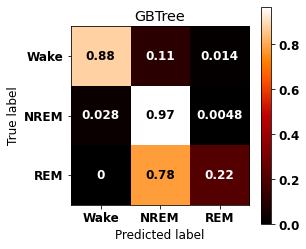

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

font = {
    'weight' : 'bold',
    'size'   : 12
    }
plt.rc('font', **font)

fig, ax= plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test, Y_inter)
cm2 = cm.copy().astype('float')
for row_id in range(cm.shape[0]):
    for col_id in range(cm.shape[1]):
        cm2[row_id, col_id] = cm[row_id, col_id] / cm[row_id].sum()
dis = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Wake','NREM','REM'], )
dis.plot(cmap=plt.cm.gist_heat, ax=ax);
# plt.gca().set_xlabel('Human')
# plt.gca().set_ylabel('Classifier')
plt.title("GBTree")

<AxesSubplot:ylabel='label'>

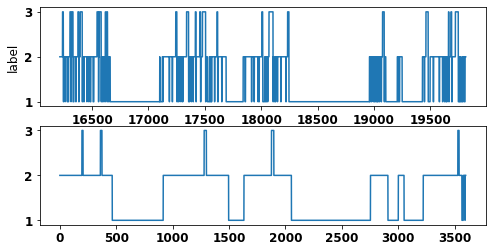

In [25]:
step = 9
step_width = 3600
fig, axs = plt.subplots(2, 1, figsize=(8, 4))
sns.lineplot(
    data = Y_inter[step * step_width: (step+1) * step_width], ax = axs[1]
)
sns.lineplot(
    data = y_test[step * step_width: (step+1) * step_width], ax = axs[0]
)

In [21]:
from sklearn.neighbors import KNeighborsClassifier

model_smooth = KNeighborsClassifier(4)

inter_y_hat = pd.DataFrame({
    'y_inter': Y_inter,
    'time': range(Y_inter.shape[0])
})
model_smooth.fit(inter_y_hat.time.values[:,np.newaxis], inter_y_hat.y_inter)
Y_hat = model_smooth.predict(inter_y_hat.time.values[:,np.newaxis])

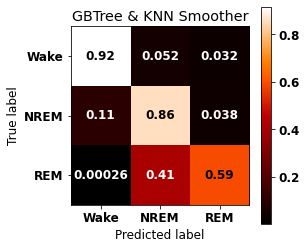

In [22]:
font = {
    'weight' : 'bold',
    'size'   : 12
    }
plt.rc('font', **font)

fig, ax= plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test, Y_hat)
cm2 = cm.copy().astype('float')
for row_id in range(cm.shape[0]):
    for col_id in range(cm.shape[1]):
        cm2[row_id, col_id] = cm[row_id, col_id] / cm[row_id].sum()
dis = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Wake','NREM','REM'], )
dis.plot(cmap=plt.cm.gist_heat, ax=ax);
plt.title("GBTree & KNN Smoother");
#plt.savefig("./data/GBT_acc.pdf", format='pdf')

In [ ]:
#END